In [41]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns


train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (7613, 5)
Test shape: (3263, 4)


In [42]:
print("=== Пропуски в train ===")
print(train.isnull().sum())

print("\n=== Пропуски в test ===")
print(test.isnull().sum())

=== Пропуски в train ===
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

=== Пропуски в test ===
id             0
keyword       26
location    1105
text           0
dtype: int64


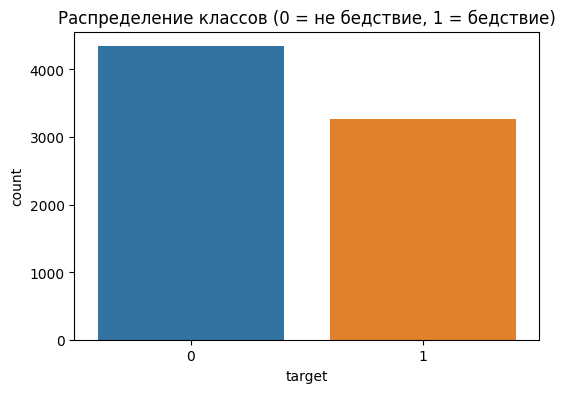

Количество 0 (не бедствие): 4342
Количество 1 (бедствие): 3271
Доля класса 1: 0.43


In [43]:
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='target')
plt.title('Распределение классов (0 = не бедствие, 1 = бедствие)')
plt.show()

class_counts = train['target'].value_counts()
print("Количество 0 (не бедствие):", class_counts[0])
print("Количество 1 (бедствие):", class_counts[1])
print("Доля класса 1:", round(class_counts[1] / len(train), 3))

In [44]:
print("Столбцы в train:", train.columns.tolist())
print("Столбцы в test:", test.columns.tolist())
# Удаляем location — слишком много пропусков и шума
train = train.drop(columns=['location'])
test = test.drop(columns=['location'])

# Заполняем keyword пропуски пустой строкой (CatBoost поймёт NaN, но для консистентности)
train['keyword'] = train['keyword'].fillna('')
test['keyword'] = test['keyword'].fillna('')

# Создаём простые фичи из текста
def extract_features(df):
    df['text_len'] = df['text'].apply(len)  # длина твита
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))  # количество слов
    df['capitals'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))  # количество заглавных
    df['exclamation_count'] = df['text'].apply(lambda x: x.count('!'))  # восклицательные знаки
    df['question_count'] = df['text'].apply(lambda x: x.count('?'))  # вопросительные знаки
    df['hashtag_count'] = df['text'].apply(lambda x: x.count('#'))  # хештеги
    df['mention_count'] = df['text'].apply(lambda x: x.count('@'))  # упоминания
    return df

train = extract_features(train)
test = extract_features(test)

Столбцы в train: ['id', 'keyword', 'location', 'text', 'target']
Столбцы в test: ['id', 'keyword', 'location', 'text']


In [45]:
# Признаки для обучения
features = ['keyword', 'text_len', 'word_count', 'capitals', 'exclamation_count', 
            'question_count', 'hashtag_count', 'mention_count']

X = train[features]
y = train['target']
X_test = test[features]

# Разделение на train/val для валидации (опционально, можно и без него)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [46]:
# ============ ШАГ 1: Извлекаем базовые фичи ============
def extract_features(df):
    df['text_len'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['capitals'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))
    df['exclamation_count'] = df['text'].apply(lambda x: x.count('!'))
    df['question_count'] = df['text'].apply(lambda x: x.count('?'))
    df['hashtag_count'] = df['text'].apply(lambda x: x.count('#'))
    df['mention_count'] = df['text'].apply(lambda x: x.count('@'))
    return df

train = extract_features(train)
test = extract_features(test)

# ============ ШАГ 2: Добавляем TF-IDF ко ВСЕМУ train и test ============
from sklearn.feature_extraction.text import TfidfVectorizer

# Обучаем на всех текстах
all_text = pd.concat([train['text'], test['text']], ignore_index=True)

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    lowercase=True,
    strip_accents='unicode'
)

tfidf.fit(all_text)

# Преобразуем
X_train_tfidf = tfidf.transform(train['text'])
X_test_tfidf = tfidf.transform(test['text'])

# В DataFrame
tfidf_feature_names = [f"tfidf_{i}" for i in range(X_train_tfidf.shape[1])]
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_feature_names)
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_feature_names)

# ============ ШАГ 3: Объединяем ВСЕ фичи ДО разделения ============
# Базовые фичи + TF-IDF
features_basic = ['keyword', 'text_len', 'word_count', 'capitals', 
                  'exclamation_count', 'question_count', 'hashtag_count', 'mention_count']

X_full = pd.concat([train[features_basic].reset_index(drop=True), X_train_tfidf_df], axis=1)
X_test_full = pd.concat([test[features_basic].reset_index(drop=True), X_test_tfidf_df], axis=1)
y_full = train['target']

# ============ ШАГ 4: Теперь делим на train/val ============
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print("X_train shape:", X_train.shape)  # должно быть ~6090 строк
print("y_train shape:", y_train.shape)  # должно совпадать

X_train shape: (6090, 5008)
y_train shape: (6090,)


In [47]:
cat_features_updated = ['keyword']  # остальные — числовые

model_tfidf = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

model_tfidf.fit(
    X_train, y_train,
    cat_features=cat_features_updated,
    eval_set=(X_val, y_val),
    use_best_model=True,
    verbose=100
)

# Оценка
val_preds_tfidf = model_tfidf.predict(X_val)
val_f1_tfidf = f1_score(y_val, val_preds_tfidf)
print(f"\n✅ Новый F1-score на валидации с TF-IDF: {val_f1_tfidf:.4f}")

0:	learn: 0.6517124	test: 0.6764228	best: 0.6764228 (0)	total: 83.7ms	remaining: 1m 23s
100:	learn: 0.7065771	test: 0.7220447	best: 0.7232000 (78)	total: 4.14s	remaining: 36.9s
200:	learn: 0.7386688	test: 0.7376000	best: 0.7376000 (193)	total: 8.21s	remaining: 32.7s
300:	learn: 0.7623925	test: 0.7453815	best: 0.7459807 (291)	total: 12.3s	remaining: 28.7s
400:	learn: 0.7834290	test: 0.7552335	best: 0.7562349 (387)	total: 16.4s	remaining: 24.5s
500:	learn: 0.8003277	test: 0.7606085	best: 0.7606085 (488)	total: 20.5s	remaining: 20.5s
600:	learn: 0.8199673	test: 0.7581804	best: 0.7613727 (554)	total: 24.6s	remaining: 16.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7613727055
bestIteration = 554

Shrink model to first 555 iterations.

✅ Новый F1-score на валидации с TF-IDF: 0.7614


In [48]:
# Предсказание на тестовых данных
test_preds = model.predict(X_test)

# Формируем сабмит
submission['target'] = test_preds.astype(int)
submission.to_csv('submission.csv', index=False)

print("✅ Файл submission.csv готов!")

✅ Файл submission.csv готов!


In [52]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.model_selection import train_test_split

!pip install -q keras-core --upgrade
!pip install -q keras-nlp --upgrade

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

X = df_train["text"]
y = df_train["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test["text"]

preset = "distil_bert_base_en_uncased"
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160)
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, preprocessor=preprocessor, num_classes=2)

classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),
    metrics=["accuracy"]
)

classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=2,
    validation_data=(X_val, y_val)
)

sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)
sample_submission.to_csv("submission.csv", index=False)

Using TensorFlow backend
^C



KeyboardInterrupt

